In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import KFold

In [66]:
df = pd.read_csv("../Data/raw/train.csv")
df.head()

,id,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment,Listening_Time_minutes
0,0,Mystery Matters,Episode 98,NaN,True Crime,74.81,Thursday,Night,NaN,0.0,Positive,31.41998
1,1,Joke Junction,Episode 26,119.80,Comedy,66.95,Saturday,Afternoon,75.95,2.0,Negative,88.01241
2,2,Study Sessions,Episode 16,73.90,Education,69.97,Tuesday,Evening,8.97,0.0,Negative,44.92531
3,3,Digital Digest,Episode 45,67.17,Technology,57.22,Monday,Morning,78.70,2.0,Positive,46.27824
4,4,Mind & Body,Episode 86,110.51,Health,80.07,Monday,Afternoon,58.68,3.0,Neutral,75.61031


In [67]:
df.describe()

,id,Episode_Length_minutes,Host_Popularity_percentage,Guest_Popularity_percentage,Number_of_Ads,Listening_Time_minutes
count,750000.000000,662907.000000,750000.000000,603970.000000,749999.000000,750000.000000
mean,374999.500000,64.504738,59.859901,52.236449,1.348855,45.437406
std,216506.495284,32.969603,22.873098,28.451241,1.151130,27.138306
min,0.000000,0.000000,1.300000,0.000000,0.000000,0.000000
25%,187499.750000,35.730000,39.410000,28.380000,0.000000,23.178350
50%,374999.500000,63.840000,60.050000,53.580000,1.000000,43.379460
75%,562499.250000,94.070000,79.530000,76.600000,2.000000,64.811580
max,749999.000000,325.240000,119.460000,119.910000,103.910000,119.970000


# Missing Values

Dealing with null data

In [68]:
df.isna().sum()

id                                  0
Podcast_Name                        0
Episode_Title                       0
Episode_Length_minutes          87093
Genre                               0
Host_Popularity_percentage          0
Publication_Day                     0
Publication_Time                    0
Guest_Popularity_percentage    146030
Number_of_Ads                       1
Episode_Sentiment                   0
Listening_Time_minutes              0
dtype: int64

In [69]:
# Groups the data by "Genre" and calculates the total number of missing values (NaNs) in each column for each genre
nulls_percentage = df.groupby("Genre").apply(lambda x: x.isna().sum())

# Adds a "Total" column, which contains the count of non-missing values in the "id" column for each genre.
nulls_percentage["Total"] = df[["Genre", "id"]].groupby("Genre").count()

# Keeps only the "Episode_Length_minutes" and "Total" columns for further analysis.
nulls_percentage = nulls_percentage[["Episode_Length_minutes", "Total"]]

# Calculates the percentage of missing values in the "Episode_Length_minutes" column relative to the "Total" count for each genre.
nulls_percentage.apply(lambda x: x["Episode_Length_minutes"]*100/x["Total"], axis=1)

C:\Users\keato\AppData\Local\Temp\ipykernel_23096\3827178227.py:2: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  nulls_percentage = df.groupby("Genre").apply(lambda x: x.isna().sum())


Genre
Business      11.502589
Comedy        11.676672
Education     11.885947
Health        11.161364
Lifestyle     11.031882
Music         11.370193
News          12.023349
Sports        12.035705
Technology    12.065248
True Crime    11.415606
dtype: float64

<Axes: >

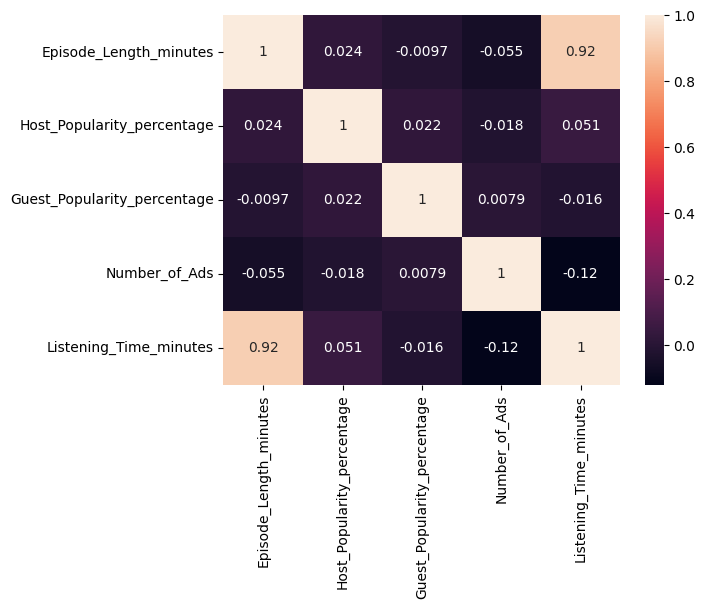

In [70]:
# Compute the correlation matrix for selected numerical columns in the DataFrame
corr_matrix = df[["Episode_Length_minutes", "Host_Popularity_percentage", "Guest_Popularity_percentage", "Number_of_Ads", "Listening_Time_minutes"]].corr()
sns.heatmap(corr_matrix, annot=True)

<Axes: xlabel='Genre', ylabel='Episode_Length_minutes'>

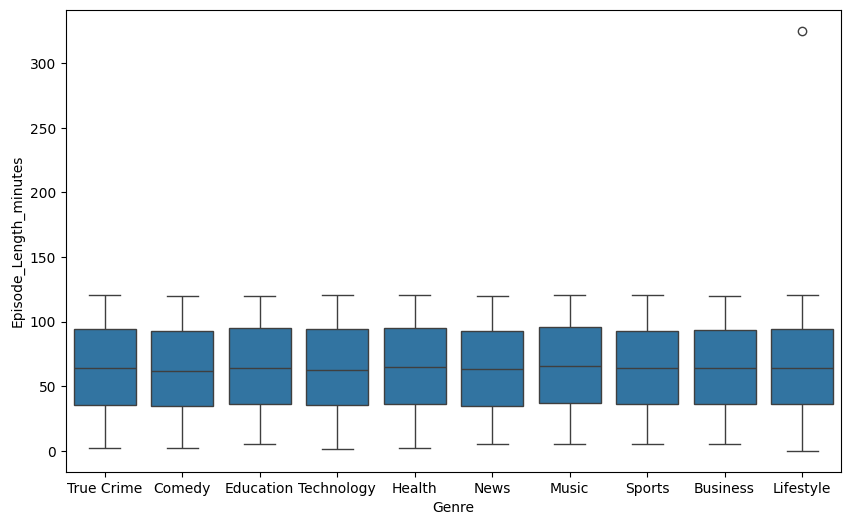

In [71]:
# Create a box plot to show the distribution of "Episode_Length_minutes" across different "Genre" categories
plt.figure(figsize=(10,6))
sns.boxplot(data= df, x= "Genre", y="Episode_Length_minutes")

In [72]:
# Checking and removing Outliers
df.drop(df[df["Episode_Length_minutes"]>150].index, axis=0 ,inplace=True)

In [73]:
# Replace missing values in "Episode_Length_minutes" with the column's mean value
df["Episode_Length_minutes"] = df["Episode_Length_minutes"].fillna(df["Episode_Length_minutes"].mean())

<Figure size 2000x1000 with 0 Axes>

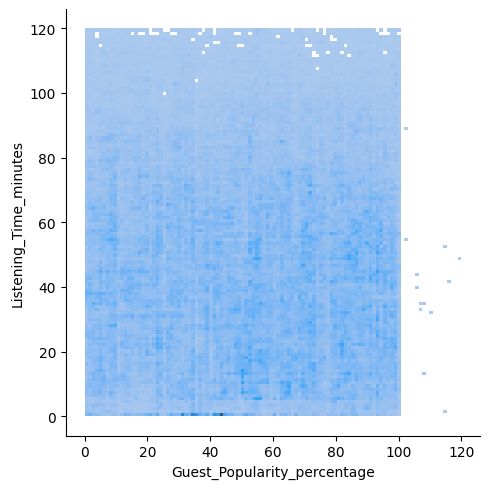

In [74]:
plt.figure(figsize=(20,10))
sns.displot(data=df, x="Guest_Popularity_percentage", y="Listening_Time_minutes")

## Experiment
Experiment to know the relevance of the Guest_Popularity_percentage, since the correlation matrix shows an almost nule correlation but I think this featue could have a non-linear correlation

In [75]:
df_exp = df.copy()

# Define features and target
target = 'Listening_Time_minutes'  # replace with the actual name of your target variable

# Numeric + categorical features (using only clean columns for now)
features = [col for col in df_exp.columns if col != target]

# One-hot encoding for categorical variables (like Genre, etc.)
df_encoded = pd.get_dummies(df_exp[features], drop_first=True)

X_full = df_encoded
y = df_exp[target]

X_with_feature = X_full.copy()
X_without_feature = X_full.drop(columns=['Guest_Popularity_percentage'], errors='ignore')

def train_and_evaluate(X, y, name):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model = RandomForestRegressor(random_state=42, n_jobs=-1)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"🔍 Model results: {name}")
    print(f"MAE: {mae:.2f}")
    print(f"R² : {r2:.4f}")
    return model


In [76]:
run_experiment = False  # Change to True to run the experiment (It will take several minutes)

if run_experiment:
    model_with = train_and_evaluate(X_with_feature, y, "With 'Guest_Popularity_percentage'")
    model_without = train_and_evaluate(X_without_feature, y, "Without 'Guest_Popularity_percentage'")

In [77]:
if run_experiment:
    importances = pd.Series(model_with.feature_importances_, index=X_with_feature.columns)
    importances.sort_values(ascending=False).head(10).plot(kind='barh', figsize=(10,6))
    plt.title("Top 10 Most Important Features (Model with 'Guest_Popularity')")
    plt.gca().invert_yaxis()
    plt.show()

As I spected, there is a non-linear correlation that can be useful for the last model

## Imputation values of Guest_Popularity

In [78]:
# Pertenace of Null values on Guest_Popularity_percentage column
Guest_popularity_nulls = df.groupby("Genre").apply(lambda x: x.isnull().sum())
Guest_popularity_nulls["Total"] =  df[["Genre", "id"]].groupby("Genre").count()
Guest_popularity_nulls_percentage = Guest_popularity_nulls.apply(lambda x: x["Guest_Popularity_percentage"]*100/x["Total"], axis=1)
Guest_popularity_nulls_percentage

C:\Users\keato\AppData\Local\Temp\ipykernel_23096\1815148135.py:2: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  Guest_popularity_nulls = df.groupby("Genre").apply(lambda x: x.isnull().sum())


Genre
Business      20.833075
Comedy        18.188403
Education     20.967413
Health        18.543464
Lifestyle     18.391948
Music         18.582153
News          20.624753
Sports        20.240623
Technology    20.368438
True Crime    18.461303
dtype: float64

In [79]:
# Create a new column 'Guest_Popularity_missing' that indicates whether the 'Guest_Popularity_percentage' column has missing values (1 for missing, 0 otherwise)
df['Guest_Popularity_missing'] = df['Guest_Popularity_percentage'].isna().astype(int)

# Group the data by the 'Genre' column and fill missing values in 'Guest_Popularity_percentage' with the median of the respective group
df["Guest_Popularity_percentage"] = df.groupby("Genre")["Guest_Popularity_percentage"].transform(lambda x: x.fillna(x.median()))

In [80]:
# Remove one row that has a null value on number of adds
df = df.dropna()
df.shape

(749998, 13)

# Features Encoding

In [81]:
df.dtypes

id                               int64
Podcast_Name                    object
Episode_Title                   object
Episode_Length_minutes         float64
Genre                           object
Host_Popularity_percentage     float64
Publication_Day                 object
Publication_Time                object
Guest_Popularity_percentage    float64
Number_of_Ads                  float64
Episode_Sentiment               object
Listening_Time_minutes         float64
Guest_Popularity_missing         int64
dtype: object

In [82]:
X = df.drop(columns="Listening_Time_minutes")
y = df["Listening_Time_minutes"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [83]:

genre_target_mean = X_train.join(y_train).groupby("Genre")["Listening_Time_minutes"].mean()

joblib.dump(genre_target_mean, "../artifacts/genre_target_mean.pkl")

X_train["Genre_encoded"] = X_train["Genre"].map(genre_target_mean)
X_test["Genre_encoded"] = X_test["Genre"].map(genre_target_mean)

global_mean = y_train.mean()

In [84]:
X_train.drop(columns="Genre")

,id,Podcast_Name,Episode_Title,Episode_Length_minutes,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment,Guest_Popularity_missing,Genre_encoded
202844,202844,Game Day,Episode 30,119.97,64.21,Saturday,Night,17.93,0.0,Negative,0,44.913404
110926,110926,Lifestyle Lounge,Episode 57,62.57,27.22,Friday,Morning,50.84,1.0,Positive,0,45.440905
200533,200533,World Watch,Episode 93,99.12,82.95,Tuesday,Morning,93.62,1.0,Negative,0,44.371825
285483,285483,Sports Central,Episode 30,91.05,99.51,Thursday,Evening,13.44,3.0,Neutral,0,44.913404
79612,79612,Fashion Forward,Episode 26,61.42,23.48,Monday,Afternoon,5.69,1.0,Negative,0,45.440905
...,...,...,...,...,...,...,...,...,...,...,...,...
259180,259180,Sound Waves,Episode 86,63.41,20.34,Sunday,Night,67.59,2.0,Neutral,0,46.533255
365840,365840,Tune Time,Episode 80,61.19,38.87,Sunday,Morning,0.83,0.0,Neutral,0,46.533255
131933,131933,Fitness First,Episode 55,19.40,39.77,Sunday,Morning,52.85,1.0,Negative,0,45.819181
671157,671157,Daily Digest,Episode 69,17.51,92.29,Friday,Evening,57.35,0.0,Neutral,0,44.371825


### Target encoding

In [85]:
encoded_df = X_train.join(y_train).reset_index(drop=True)

day_map = {
    'Monday': 0, 'Tuesday': 1, 'Wednesday': 2,
    'Thursday': 3, 'Friday': 4, 'Saturday': 5, 'Sunday': 6
}

time_map = {
    'Night': 1,
    'Morning': 9,
    'Afternoon': 15,
    'Evening': 20
}

encoded_df["Publication_Time"] = encoded_df["Publication_Time"].map(time_map)
encoded_df["Publication_Day"] = encoded_df["Publication_Day"].map(day_map)

# Encoding for  hours (0-23)
encoded_df["Time_sin"] = np.sin(2 * np.pi * encoded_df["Publication_Time"] / 24)
encoded_df["Time_cos"] = np.cos(2 * np.pi * encoded_df["Publication_Time"] / 24)

# encoding for days (0-6)
encoded_df["Day_sin"] = np.sin(2 * np.pi * encoded_df["Publication_Day"] / 7)
encoded_df["Day_cos"] = np.cos(2 * np.pi * encoded_df["Publication_Day"] / 7)


encoded_df.drop(columns=["Publication_Time", "Publication_Day", "Genre"], inplace=True)


In [86]:
encoded_df.Episode_Sentiment.unique()

array(['Negative', 'Positive', 'Neutral'], dtype=object)

In [87]:
seniment_map = {
    'Negative': -1,
    'Neutral': 0,
    'Positive': 1
}

encoded_df["Episode_Sentiment"] = encoded_df["Episode_Sentiment"].map(seniment_map)

In [88]:
len(encoded_df.Podcast_Name.unique())

48

In [89]:
# Import KFold from sklearn (if not already imported)
from sklearn.model_selection import KFold

# Create the K-Fold cross-validation object with 5 splits,
# shuffling the data and setting a random seed for reproducibility
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Initialize a new column to store the encoded values.
# Fill it initially with NaN.
encoded_df["Podcast_Encoded"] = np.nan

# Iterate over each fold of the K-Fold split
for train_idx, val_idx in kf.split(encoded_df):
    # Split the DataFrame into training and validation subsets
    train, val = encoded_df.iloc[train_idx], encoded_df.iloc[val_idx]

    # Calculate the mean of the target variable ('Listening_Time_minutes') 
    # for each category in 'Podcast_Name', using only the training data
    means = train.groupby("Podcast_Name")["Listening_Time_minutes"].mean()

    # Map the computed means to the validation set,
    # encoding 'Podcast_Name' without leaking validation data into training
    encoded_df.loc[val_idx, "Podcast_Encoded"] = val["Podcast_Name"].map(means)

# Calculate the mean listening time for each podcast using the entire encoded dataset.
# This mapping will be used later to encode new/unseen datasets consistently.
final_means = encoded_df.groupby("Podcast_Name")["Listening_Time_minutes"].mean()

# Save the computed mapping to a file using joblib for reuse in other notebooks or production environments.
joblib.dump(final_means, '../artifacts/podcast_target_encoding.pkl')

# Drop the original categorical column, since it has been replaced by its numerical encoding
joblib.dump(encoded_df["Podcast_Name"], "../artifacts/Podcast_names_list.pkl")
encoded_df.drop("Podcast_Name", axis=1, inplace=True)


In [90]:
encoded_df["Episode_Title"] = encoded_df["Episode_Title"].map(lambda x: x.lstrip("Episode ")).astype("int")

In [91]:
encoded_df

,id,Episode_Title,Episode_Length_minutes,Host_Popularity_percentage,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment,Guest_Popularity_missing,Genre_encoded,Listening_Time_minutes,Time_sin,Time_cos,Day_sin,Day_cos,Podcast_Encoded
0,202844,30,119.97,64.21,17.93,0.0,-1,0,44.913404,57.67601,0.258819,0.965926,-0.974928,-0.222521,43.980881
1,110926,57,62.57,27.22,50.84,1.0,1,0,45.440905,48.82398,0.707107,-0.707107,-0.433884,-0.900969,45.628020
2,200533,93,99.12,82.95,93.62,1.0,-1,0,44.371825,82.95502,0.707107,-0.707107,0.781831,0.623490,43.996397
3,285483,30,91.05,99.51,13.44,3.0,0,0,44.913404,71.68635,-0.866025,0.500000,0.433884,-0.900969,41.702596
4,79612,26,61.42,23.48,5.69,1.0,-1,0,45.440905,50.45880,-0.707107,-0.707107,0.000000,1.000000,45.239931
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
599993,259180,86,63.41,20.34,67.59,2.0,0,0,46.533255,32.06549,0.258819,0.965926,-0.781831,0.623490,44.461635
599994,365840,80,61.19,38.87,0.83,0.0,0,0,46.533255,53.73476,0.707107,-0.707107,-0.781831,0.623490,47.007739
599995,131933,55,19.40,39.77,52.85,1.0,-1,0,45.819181,13.09288,0.707107,-0.707107,-0.781831,0.623490,45.873295
599996,671157,69,17.51,92.29,57.35,0.0,0,0,44.371825,13.36094,-0.866025,0.500000,-0.433884,-0.900969,45.814585


# Export new df

In [92]:
encoded_df.to_csv("../Data/processed/encoded_df.csv", index=False)

# Feature Engineering

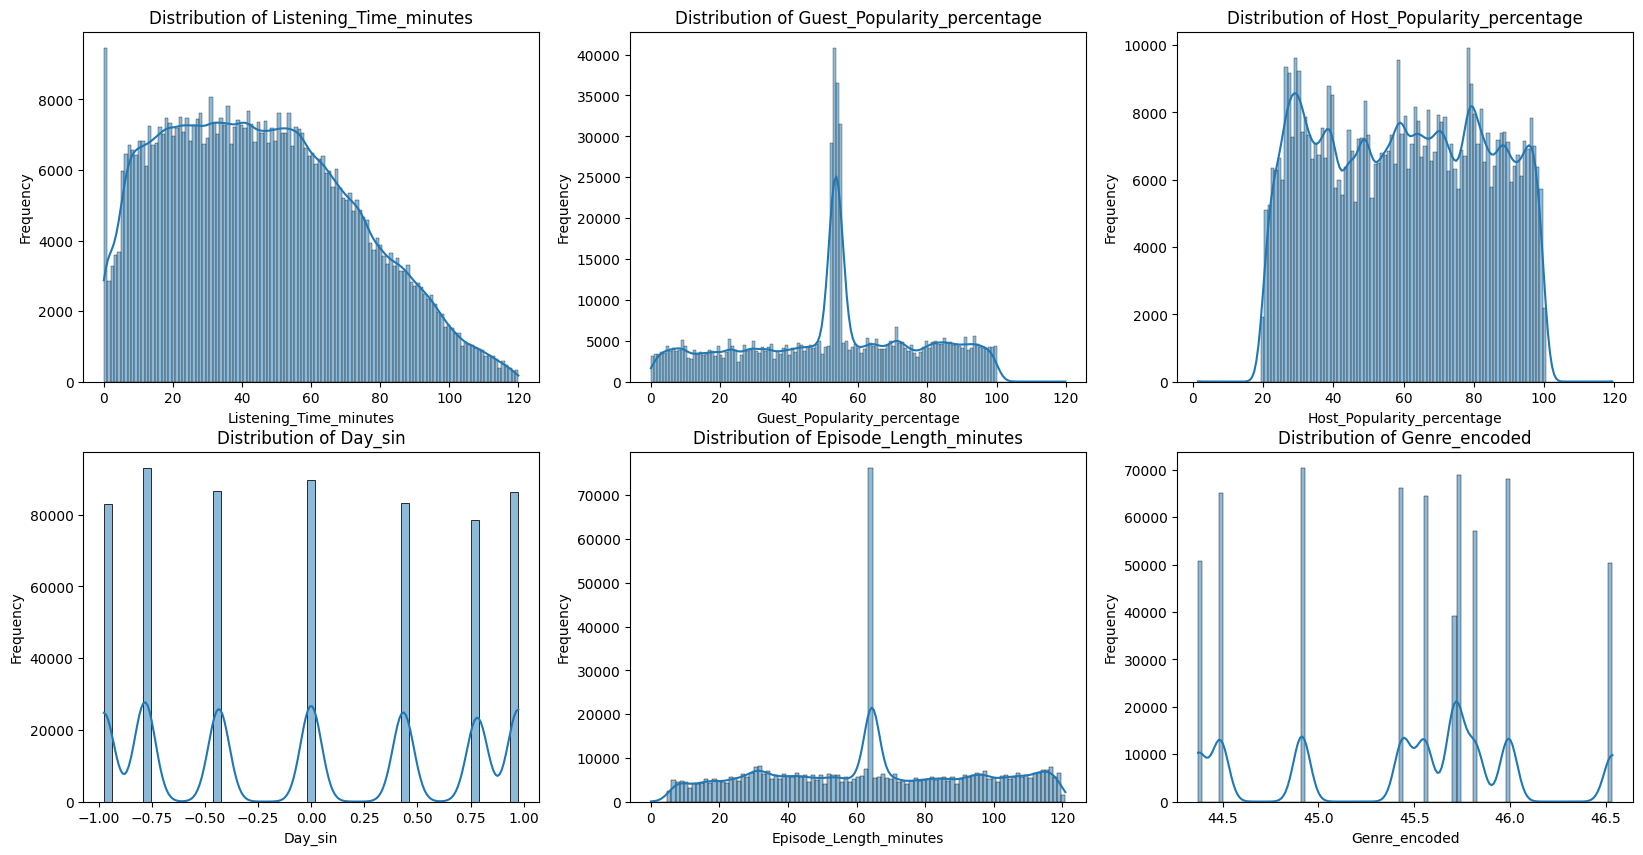

In [93]:
columns = ['Listening_Time_minutes', 'Guest_Popularity_percentage', 'Host_Popularity_percentage',
           'Day_sin', 'Episode_Length_minutes', 'Genre_encoded']

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 10))

for i, col in enumerate(columns):
    ax = axes[i // 3, i % 3]
    sns.histplot(data=encoded_df, x=col, ax=ax, kde=True)
    ax.set_title(f"Distribution of {col}")
    ax.set_xlabel(col)
    ax.set_ylabel("Frequency")

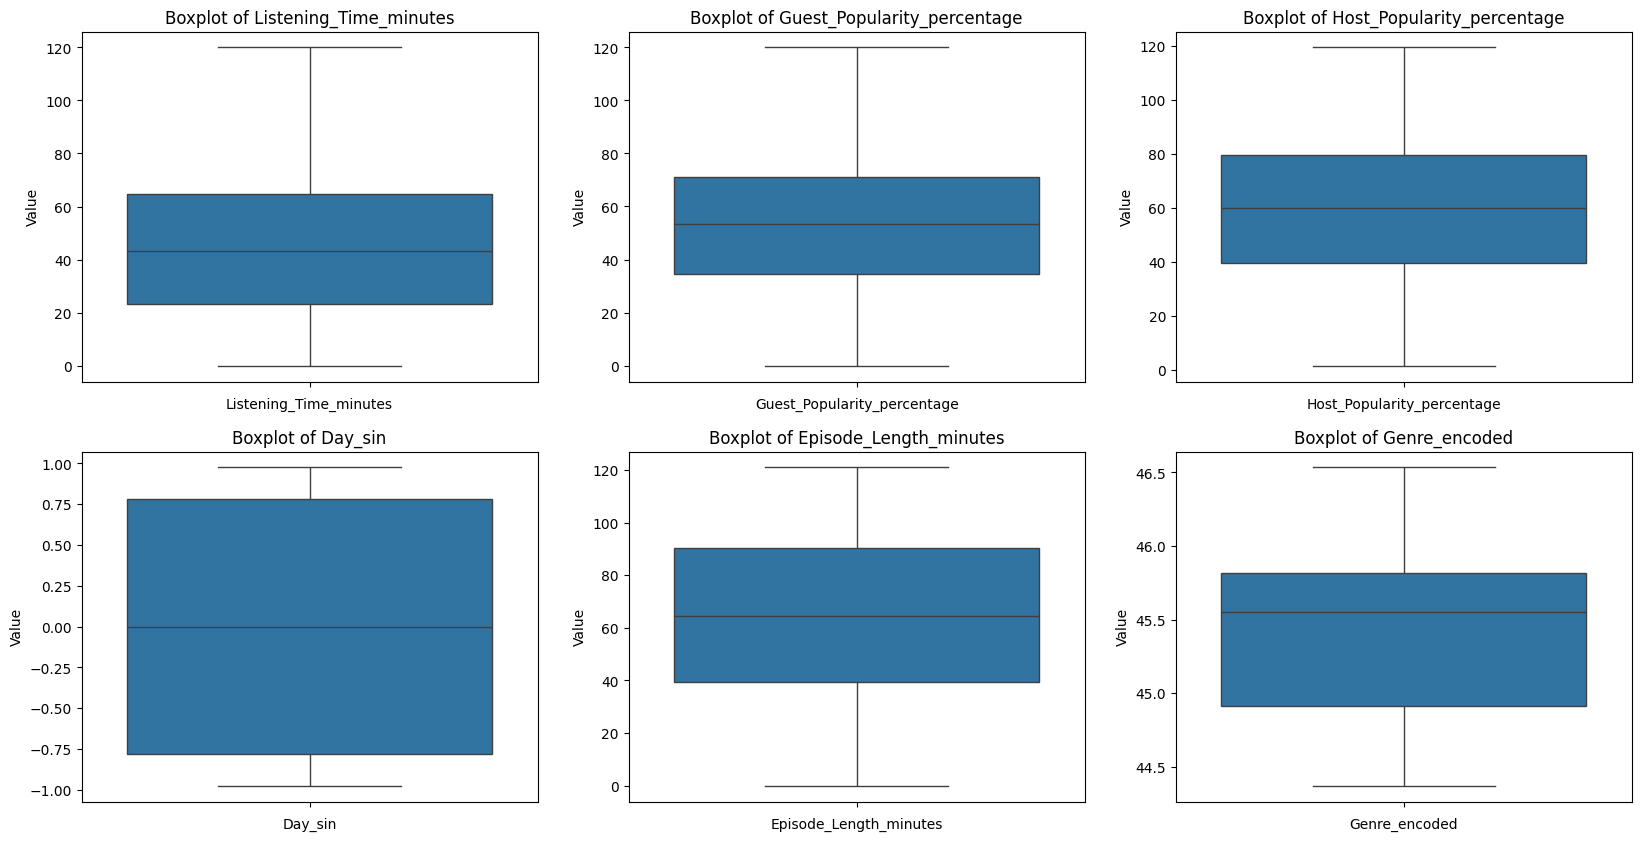

In [94]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 10))

for i, col in enumerate(columns):
    ax = axes[i // 3, i % 3]
    sns.boxplot(data=encoded_df, y=col, ax=ax, showfliers=True)
    ax.set_title(f"Boxplot of {col}")
    ax.set_xlabel(col)
    ax.set_ylabel("Value")

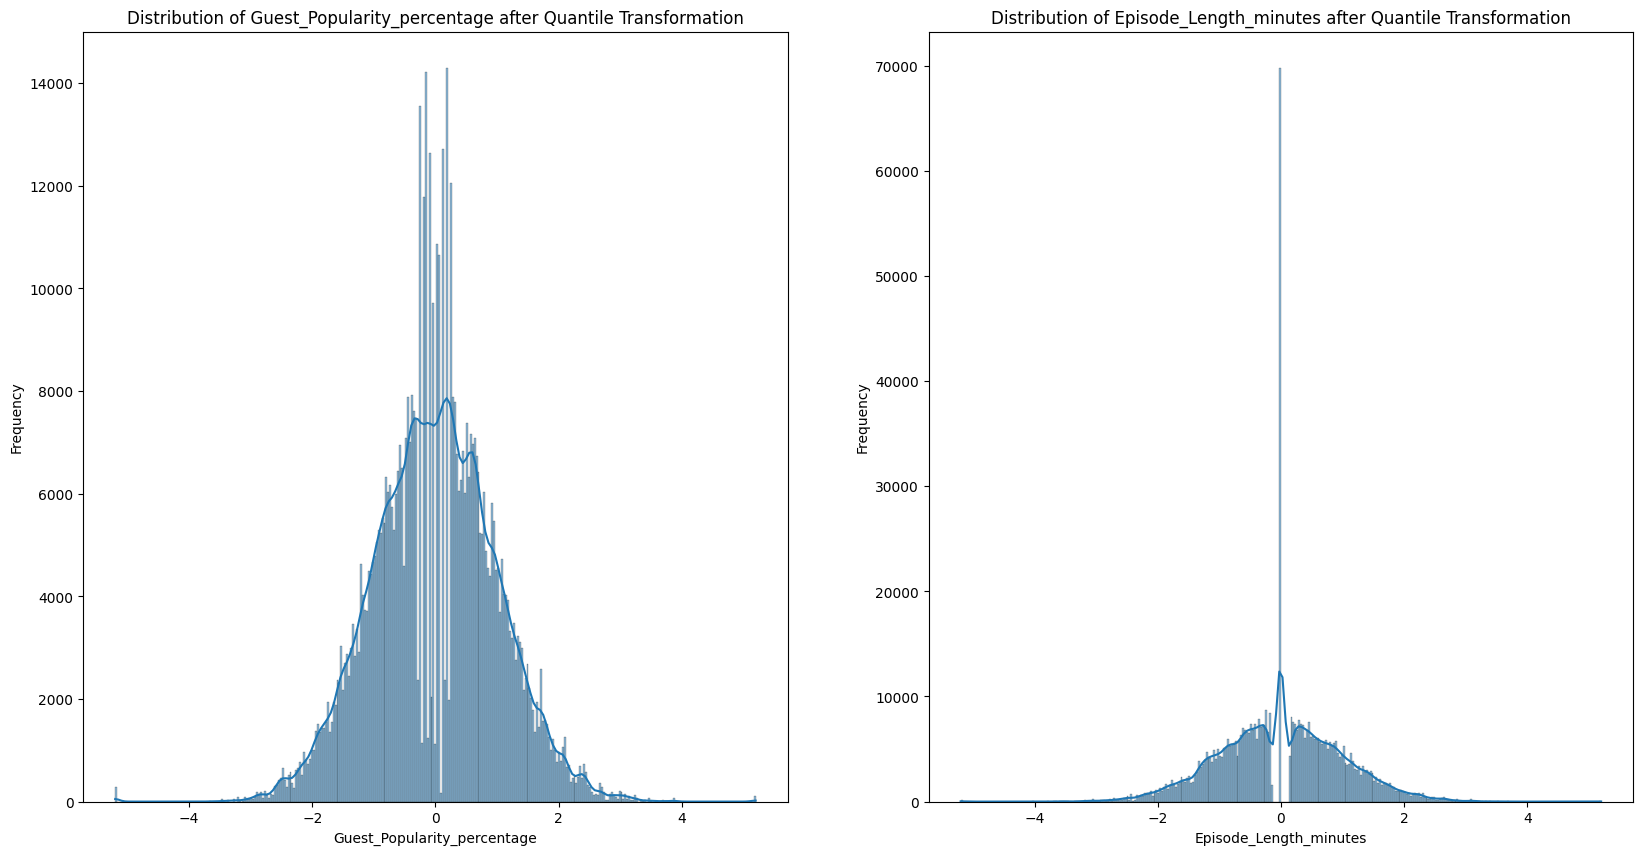

In [95]:
from sklearn.preprocessing import QuantileTransformer

enriched_df = encoded_df.copy()
qt = QuantileTransformer(output_distribution='normal', random_state=42)
enriched_df["Guest_Popularity_percentage"] = qt.fit_transform(enriched_df[["Guest_Popularity_percentage"]])
enriched_df["Episode_Length_minutes"] = qt.fit_transform(enriched_df[["Episode_Length_minutes"]])

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))

for i, col in enumerate(["Guest_Popularity_percentage", "Episode_Length_minutes"]):
    ax = axes[i]
    sns.histplot(data=enriched_df, x=col, ax=ax, kde=True)
    ax.set_title(f"Distribution of {col} after Quantile Transformation")
    ax.set_xlabel(col)
    ax.set_ylabel("Frequency")

In [96]:
enriched_df.to_csv("../Data/processed/enriched_df.csv", index=False)

# Generating BD for visualization

In [97]:
test_df = pd.read_csv("../Data/raw/test.csv")
dashboard_bd = df + test_df

In [98]:
enriched_df

,id,Episode_Title,Episode_Length_minutes,Host_Popularity_percentage,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment,Guest_Popularity_missing,Genre_encoded,Listening_Time_minutes,Time_sin,Time_cos,Day_sin,Day_cos,Podcast_Encoded
0,202844,30,3.692060,64.21,-1.145558,0.0,-1,0,44.913404,57.67601,0.258819,0.965926,-0.974928,-0.222521,43.980881
1,110926,57,-0.193143,27.22,-0.326678,1.0,1,0,45.440905,48.82398,0.707107,-0.707107,-0.433884,-0.900969,45.628020
2,200533,93,0.898419,82.95,1.593219,1.0,-1,0,44.371825,82.95502,0.707107,-0.707107,0.781831,0.623490,43.996397
3,285483,30,0.667506,99.51,-1.308513,3.0,0,0,44.913404,71.68635,-0.866025,0.500000,0.433884,-0.900969,41.702596
4,79612,26,-0.220904,23.48,-1.758824,1.0,-1,0,45.440905,50.45880,-0.707107,-0.707107,0.000000,1.000000,45.239931
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
599993,259180,86,-0.173675,20.34,0.573790,2.0,0,0,46.533255,32.06549,0.258819,0.965926,-0.781831,0.623490,44.461635
599994,365840,80,-0.225571,38.87,-2.546408,0.0,0,0,46.533255,53.73476,0.707107,-0.707107,-0.781831,0.623490,47.007739
599995,131933,55,-1.330804,39.77,-0.111560,1.0,-1,0,45.819181,13.09288,0.707107,-0.707107,-0.781831,0.623490,45.873295
599996,671157,69,-1.413874,92.29,0.324892,0.0,0,0,44.371825,13.36094,-0.866025,0.500000,-0.433884,-0.900969,45.814585


In [99]:
encoded_df

,id,Episode_Title,Episode_Length_minutes,Host_Popularity_percentage,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment,Guest_Popularity_missing,Genre_encoded,Listening_Time_minutes,Time_sin,Time_cos,Day_sin,Day_cos,Podcast_Encoded
0,202844,30,119.97,64.21,17.93,0.0,-1,0,44.913404,57.67601,0.258819,0.965926,-0.974928,-0.222521,43.980881
1,110926,57,62.57,27.22,50.84,1.0,1,0,45.440905,48.82398,0.707107,-0.707107,-0.433884,-0.900969,45.628020
2,200533,93,99.12,82.95,93.62,1.0,-1,0,44.371825,82.95502,0.707107,-0.707107,0.781831,0.623490,43.996397
3,285483,30,91.05,99.51,13.44,3.0,0,0,44.913404,71.68635,-0.866025,0.500000,0.433884,-0.900969,41.702596
4,79612,26,61.42,23.48,5.69,1.0,-1,0,45.440905,50.45880,-0.707107,-0.707107,0.000000,1.000000,45.239931
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
599993,259180,86,63.41,20.34,67.59,2.0,0,0,46.533255,32.06549,0.258819,0.965926,-0.781831,0.623490,44.461635
599994,365840,80,61.19,38.87,0.83,0.0,0,0,46.533255,53.73476,0.707107,-0.707107,-0.781831,0.623490,47.007739
599995,131933,55,19.40,39.77,52.85,1.0,-1,0,45.819181,13.09288,0.707107,-0.707107,-0.781831,0.623490,45.873295
599996,671157,69,17.51,92.29,57.35,0.0,0,0,44.371825,13.36094,-0.866025,0.500000,-0.433884,-0.900969,45.814585


In [101]:
final_means.to_dict()

{"Athlete's Arena": 46.723734650096695,
 'Brain Boost': 44.502374696903615,
 'Business Briefs': 47.1126725807403,
 'Business Insights': 44.200050789037604,
 'Comedy Corner': 44.01677780841343,
 'Crime Chronicles': 47.730286299942094,
 'Criminal Minds': 43.59860028555392,
 'Current Affairs': 43.53176316592438,
 'Daily Digest': 45.71123949943967,
 'Detective Diaries': 46.56999211685686,
 'Digital Digest': 44.894253550405566,
 'Educational Nuggets': 45.83290442009784,
 'Fashion Forward': 45.32969686896353,
 'Finance Focus': 43.2573432753232,
 'Fitness First': 45.81604068013641,
 'Funny Folks': 45.12644830757489,
 'Gadget Geek': 47.099616068476976,
 'Game Day': 43.97879716314356,
 'Global News': 45.399679196900635,
 'Health Hour': 45.30267410724407,
 'Healthy Living': 45.209574386163005,
 'Home & Living': 46.312802051194254,
 'Humor Hub': 45.85645861477878,
 'Innovators': 45.9535998601466,
 'Joke Junction': 42.63949432930387,
 'Laugh Line': 44.468066701459605,
 'Learning Lab': 45.463089379